### Importing of libraries and data loading

Import relevant libraries for data processing and model training, then load the dataset

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from datetime import timedelta
import matplotlib.pyplot as plt
import zipfile
import joblib

In [7]:
# Download Kaggle dataset
!kaggle datasets download "aslanahmedov/walmart-sales-forecast"

# Extract .zip file
file_path = 'walmart-sales-forecast.zip'

with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall()

# Load all datasets
df_features = pd.read_csv("features.csv")
df_store = pd.read_csv("stores.csv")
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

Dataset URL: https://www.kaggle.com/datasets/aslanahmedov/walmart-sales-forecast
License(s): copyright-authors
walmart-sales-forecast.zip: Skipping, found more recently modified local copy (use --force to force download)


### Data Preprocessing

In [8]:
# Drop markdown columns (not enough info)
markdown_cols = [col for col in df_features.columns if 'MarkDown' in col]
df_features = df_features.drop(columns=markdown_cols)

# Merge df_train and df_store
train_df = pd.merge(df_train,df_store,on='Store',how='left')

# Convert Store columns to string to ensure consistency
df_features['Store'] = df_features['Store'].astype(str)
df_train['Store'] = df_train['Store'].astype(str)
df_store['Store'] = df_store['Store'].astype(str)

# Convert date columns to datetime
df_features['Date'] = pd.to_datetime(df_features['Date'])
df_train['Date'] = pd.to_datetime(df_train['Date'])

# Merge df_features with df_train on 'store' and 'date'
merged_df = pd.merge(df_features, df_train, on=['Store', 'Date'], how='inner')

# Merge the result with df_stores on 'store' only
final_merged_df = pd.merge(merged_df, df_store, on='Store', how='inner')


In [9]:
final_merged_df['Date'] = pd.to_datetime(final_merged_df['Date'],errors='coerce')
final_merged_df.sort_values(by=['Date'],inplace=True)
final_merged_df.head()

,Store,Date,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday_x,Dept,Weekly_Sales,IsHoliday_y,Type,Size
0,1,2010-02-05,42.31,2.572,211.096358,8.106,False,1,24924.50,False,A,151315
330761,35,2010-02-05,27.19,2.784,135.352461,9.262,False,3,14612.19,False,B,103681
330762,35,2010-02-05,27.19,2.784,135.352461,9.262,False,4,26323.15,False,B,103681
330763,35,2010-02-05,27.19,2.784,135.352461,9.262,False,5,36414.63,False,B,103681
330764,35,2010-02-05,27.19,2.784,135.352461,9.262,False,6,11437.81,False,B,103681


In [10]:
# Drop IsHoliday_x (equal to IsHoliday_y)
final_merged_df.drop(columns='IsHoliday_x',inplace=True)
final_merged_df.rename(columns={"IsHoliday_y" : "IsHoliday"}, inplace=True)
final_merged_df.head()

,Store,Date,Temperature,Fuel_Price,CPI,Unemployment,Dept,Weekly_Sales,IsHoliday,Type,Size
0,1,2010-02-05,42.31,2.572,211.096358,8.106,1,24924.50,False,A,151315
330761,35,2010-02-05,27.19,2.784,135.352461,9.262,3,14612.19,False,B,103681
330762,35,2010-02-05,27.19,2.784,135.352461,9.262,4,26323.15,False,B,103681
330763,35,2010-02-05,27.19,2.784,135.352461,9.262,5,36414.63,False,B,103681
330764,35,2010-02-05,27.19,2.784,135.352461,9.262,6,11437.81,False,B,103681


In [11]:
le = LabelEncoder()

final_merged_df['IsHoliday'] = le.fit_transform(final_merged_df['IsHoliday'])
final_merged_df['Type'] = le.fit_transform(final_merged_df['Type'])

data = final_merged_df

data.head()

,Store,Date,Temperature,Fuel_Price,CPI,Unemployment,Dept,Weekly_Sales,IsHoliday,Type,Size
0,1,2010-02-05,42.31,2.572,211.096358,8.106,1,24924.50,0,0,151315
330761,35,2010-02-05,27.19,2.784,135.352461,9.262,3,14612.19,0,1,103681
330762,35,2010-02-05,27.19,2.784,135.352461,9.262,4,26323.15,0,1,103681
330763,35,2010-02-05,27.19,2.784,135.352461,9.262,5,36414.63,0,1,103681
330764,35,2010-02-05,27.19,2.784,135.352461,9.262,6,11437.81,0,1,103681


In [ ]:
data.tail()

,Store,Date,Temperature,Fuel_Price,CPI,Unemployment,Dept,Weekly_Sales,IsHoliday,Type,Size
399021,4,2012-10-26,46.97,3.755,131.193097,5.621,47,7770.71,0,0,219622
399022,4,2012-10-26,46.97,3.755,131.193097,5.621,48,1486.00,0,0,219622
399023,4,2012-10-26,46.97,3.755,131.193097,5.621,50,4738.93,0,0,219622
399024,35,2012-10-26,41.80,3.686,199.219532,6.195,3,32699.78,0,0,196321
399025,39,2012-10-26,58.85,3.882,192.308899,8.667,79,1076.80,0,1,118221


In [ ]:
data.to_csv('data_lstm.csv')

In [ ]:
# Aggregate sales data for plotting
sales_data = data[['Date', 'Weekly_Sales']]

sales_data['Date'] = pd.to_datetime(sales_data['Date'])

# Set Date as index
sales_data = sales_data.set_index('Date')

# Resample to weekly frequency and calculate mean
weekly_sales = sales_data.resample('W')['Weekly_Sales'].mean().reset_index()

weekly_sales.head()


C:\Users\camil\AppData\Local\Temp\ipykernel_11292\2012940251.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Date,Weekly_Sales
0,2010-02-07,16836.121997
1,2010-02-14,16352.056032
2,2010-02-21,16216.658979
3,2010-02-28,14899.549688
4,2010-03-07,15921.015727


# Correlation Matrix

In [31]:
import plotly.graph_objects as go
import plotly.offline as po
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
pd.options.plotting.backend= "plotly"

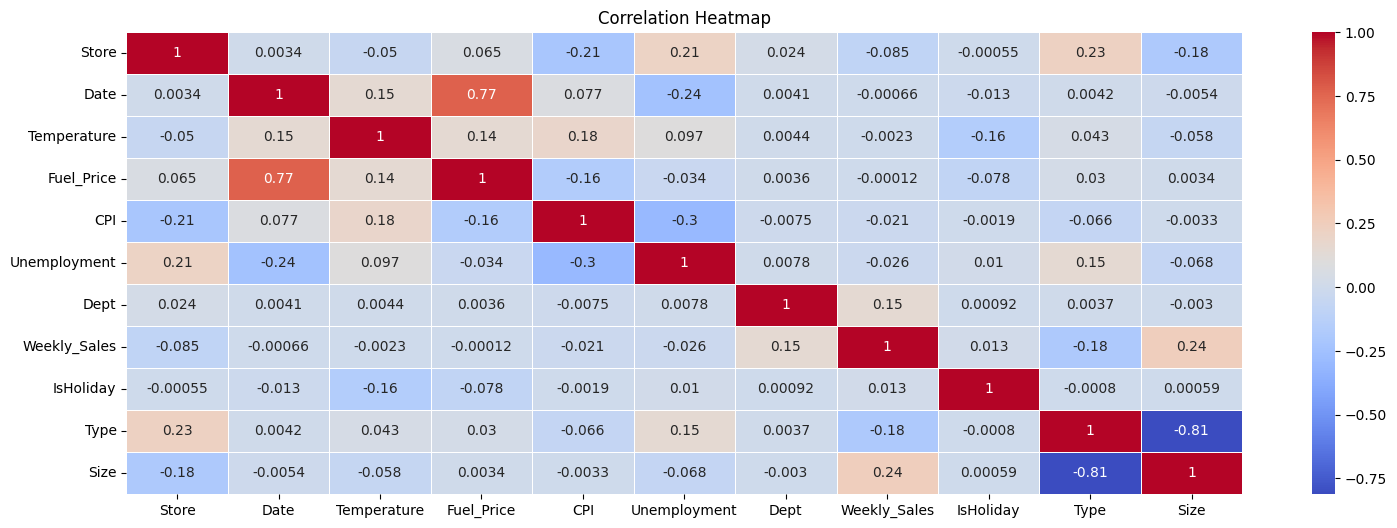

In [32]:
data = final_merged_df
correlation_matrix = data.corr()

# Plot the heatmap
plt.figure(figsize=(18, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# New Model

In [12]:
def create_sequences(data, seq_length=7):
    """Create sequences for LSTM model"""
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length, 8])  # Index 8 corresponds to Weekly_Sales
    return np.array(X), np.array(y)

# Prepare the data
data['Store'] = pd.Categorical(data['Store']).codes
data['Dept'] = pd.Categorical(data['Dept']).codes
data['Type'] = pd.Categorical(data['Type']).codes
    
# Remove outliers using z-score method
numeric_columns = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

for column in numeric_columns:
    z_scores = stats.zscore(data[column])
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < 3)
    data = data[filtered_entries]

# Reset index after removing outliers
data = data.reset_index(drop=True)

scaler_dict = {}
scaled_data = data.copy()

# Scale numeric features
numeric_features = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']

for feature in numeric_features:
    scaler = RobustScaler()
    scaled_data[feature] = scaler.fit_transform(data[feature].values.reshape(-1, 1))
    scaler_dict[feature] = scaler
    
# Create feature matrix
features = ['Store', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 
            'Dept', 'Weekly_Sales', 'IsHoliday', 'Type', 'Size']

X = scaled_data[features].values

# Create sequences
seq_length = 7
X_seq, y_seq = create_sequences(X, seq_length)

# Split into train and test
train_size = int(len(X_seq) * 0.8)
X_train = X_seq[:train_size]
y_train = y_seq[:train_size]
X_test = X_seq[train_size:]
y_test = y_seq[train_size:]

In [13]:
# Build and train model

model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, X.shape[1]), return_sequences=True),
    Dropout(0.2),
    LSTM(25, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mae')

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

model.save('ModeloLSTM.keras')
joblib.dump(scaler, 'scaler.pkl')

C:\Users\camil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8978/8978 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 0.2591 - val_loss: 0.1500
Epoch 2/10
8978/8978 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 0.1540 - val_loss: 0.1123
Epoch 3/10
8978/8978 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - loss: 0.1506 - val_loss: 0.1262
Epoch 4/10
8978/8978 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 0.1479 - val_loss: 0.1042
Epoch 5/10
8978/8978 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 0.1458 - val_loss: 0.0927
Epoch 6/10
8978/8978 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 0.1443 - val_loss: 0.1201
Epoch 7/10
8978/8978 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 0.1453 - val_loss: 0.1148
Epoch 8/10
8978/8978 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 0.1449 - val_loss: 0.1044
Epoch 9/10
8978/8978 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 0.1414 - val_loss: 0.0973
Epoch 10/10
8978/8978 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 0.1383 - val_loss: 0.1014


['scaler.pkl']

In [149]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 7, 100)         │        44,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 7, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 223,955 (874.83 KB)

 Trainable params: 74,651 (291.61 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 149,304 (583.22 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━

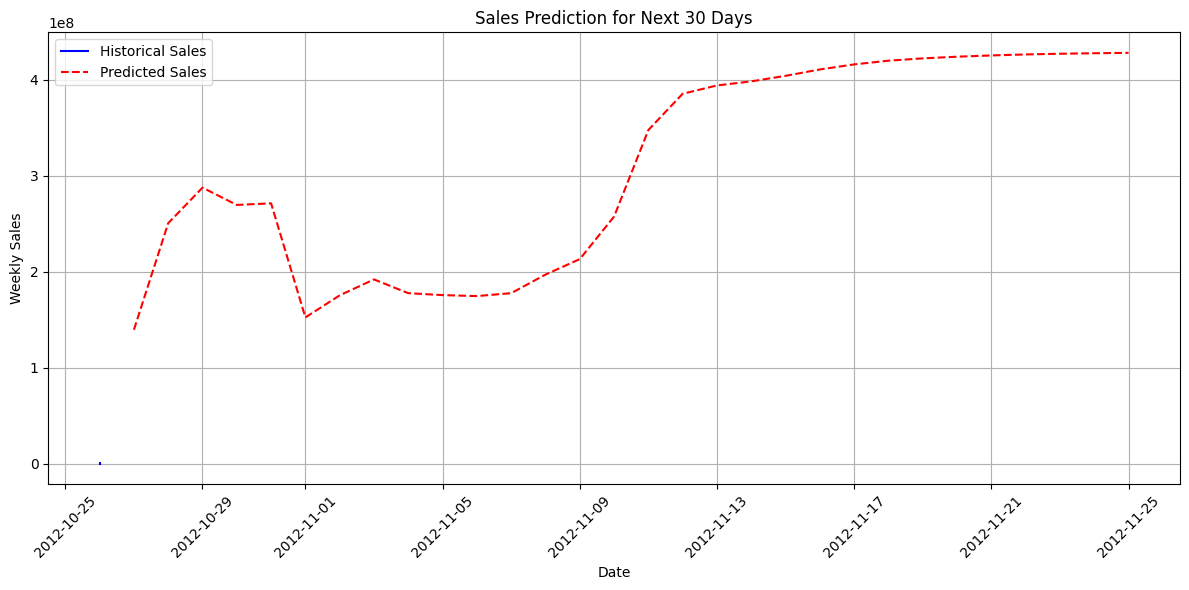

In [147]:
# Make predictions for next 30 days
last_sequence = X_seq[-1]
predictions = []
    
for _ in range(30):
    next_pred = model.predict(last_sequence.reshape(1, seq_length, X.shape[1]))
    predictions.append(next_pred[0])
    last_sequence = np.roll(last_sequence, -1, axis=0)
    last_sequence[-1] = next_pred

# Transform predictions back to original scale
sales_scaler = scaler_dict['Weekly_Sales']
predictions = sales_scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Calculate metrics for test set
y_pred = model.predict(X_test).flatten()

# Transform predictions and actual values back to original scale
sales_scaler = scaler_dict['Weekly_Sales']
predictions = sales_scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
y_pred_original = sales_scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_original = sales_scaler.inverse_transform(y_test.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
mae = mean_absolute_error(y_test_original, y_pred_original)


def plot_predictions(predictions, data):
    # Create future dates
    last_date = pd.to_datetime(data['Date'].max())
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')
    
    plt.figure(figsize=(12, 6))
    
    # Plot historical data
    plt.plot(data['Date'].tail(30), data['Weekly_Sales'].tail(30), 
             label='Historical Sales', color='blue')
    
    # Plot predictions
    plt.plot(future_dates, predictions, label='Predicted Sales', 
             color='red', linestyle='--')
    
    plt.title('Sales Prediction for Next 30 Days')
    plt.xlabel('Date')
    plt.ylabel('Weekly Sales')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    return plt


# Assuming 'data' is your DataFrame

print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')

# Plot predictions
plot = plot_predictions(predictions, data)
plot.show()

In [ ]:
# Load the data
data = pd.read_csv("train.csv")

# Calculate the average weekly sales and their standard deviation
average_weekly_sales = data['Weekly_Sales'].mean()
sd_weekly_sales = data['Weekly_Sales'].std()

print(f"The average weekly sales is: {average_weekly_sales}")
print(f"The standard deviation of weekly sales is: {sd_weekly_sales}")

The average weekly sales is: 15981.25812346704
The standard deviation of weekly sales is: 22711.18351916313


In [ ]:
# Predict on the test set
y_pred = model.predict(X_test)

# Inverse transform the scaled data
y_test_inv = scaler.inverse_transform(np.concatenate([y_test.reshape(-1, 1), np.zeros((len(y_test), len(features_to_scale) - 1))], axis=1))[:, 0]
y_pred_inv = scaler.inverse_transform(np.concatenate([y_pred.reshape(-1, 1), np.zeros((len(y_pred), len(features_to_scale) - 1))], axis=1))[:, 0]

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

2522/2522 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step
RMSE: 3691.0299435685683
MAE: 1632.8773077107417
